# Prepare Data

In [ ]:
import numpy as np
import pandas as pd
import re
import requests

# ---------------------------------------------------------------------
# Data Preprocessing Functions
# ---------------------------------------------------------------------
def drop_duplicates_except_description_and_images(df):
    
    '''
    This function is designed to identify and remove duplicate listings based on all features except for the 'description'
    and 'num_of_images' columns.
    These two fields are excluded from the comparison because duplicate apartments often have slight variations in wording
    or image count, even when all other data is identical.
    By ignoring them, we preserve only the first occurrence of each truly unique listing.
    '''
    
    cols = ['description', 'num_of_images']
    tmp = df.drop(columns=[c for c in cols if c in df.columns], errors='ignore')
    
    return df.loc[~tmp.duplicated(keep='first')]


def drop_missing_neighborhood(df):

    '''
    Removes rows with missing values in the 'neighborhood' column, as these are typically advertisements rather than actual listings.
    Excluding them helps maintain the reliability and integrity of the dataset.
    '''
    return df.dropna(subset=['neighborhood'])


def update_floor_and_total(df):

    '''
    This function cleans and standardizes the 'floor' column, which contains values scraped from the web
    and may appear in inconsistent textual formats.

    It handles the following cases:
    'קרקע מתוך קרקע' -> '0 בקומה ו- 0 בסך קומות'
    'קרקע מתוך מספר' -> '0 בקומה ומספר בסך קומות'
    'מספר מתוך מספר' -> 'מספר שכתוב מימין למילה 'מתוך' לעמודת קומה ומספר שכתוב משמאל למילה 'מתוך' לעמודת סך קומות'

    This transformation ensures that both the current floor and total_floors are extracted
    and stored as numeric values in separate columns.
    '''

    df = df.copy()
    
    for i, v in enumerate(df['floor']):
        if pd.isna(v):
            continue
            
        s = str(v).strip()
        
        if s == "קרקע מתוך קרקע":
            df.loc[i, ['floor', 'total_floors']] = [0, 0]
            
        elif re.match(r'^קרקע\s?מתוך\s?\d+$', s):
            y = int(re.findall(r'\d+', s)[0])
            df.loc[i, ['floor', 'total_floors']] = [0, y]
            
        elif re.match(r'^\d+\s?מתוך\s?\d+$', s):
            x, y = map(int, re.findall(r'\d+', s))
            df.loc[i, ['floor', 'total_floors']] = [x, y]
            
    return df


def fix_missing_total_floors(df):
    
    '''
    This function corrects missing values in the 'total_floors' column based on patterns we identified in the dataset:
    If 'floor' is 0 and 'total_floors' is missing, we assume it's a one-level building and set 'total_floors' to 0.
    If 'floor' is greater than 0 and 'total_floors' is missing, we found that in many cases the values were mistakenly swapped.
    Therefore, we move the value from 'floor' to 'total_floors' and set 'floor' to 0.
    '''
    
    df = df.copy()
    
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
    df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')

    mask0 = (df['floor'] == 0) & df['total_floors'].isna()
    df.loc[mask0, 'total_floors'] = 0

    mask_swap = (df['floor'].notna()) & (df['floor'] > 0) & df['total_floors'].isna()
    df.loc[mask_swap, ['total_floors', 'floor']] = df.loc[mask_swap, ['floor', 'total_floors']].values

    df[['floor', 'total_floors']] = df[['floor', 'total_floors']].astype('Int64')
    
    return df


def floor_from_conditions(df):
    
    '''
    This function fills in missing values for 'floor' and 'total_floors' based on textual patterns in the property description
    and specific known addresses.

    We identified that in many cases where 'total_floors' is missing, the floor number can be extracted
    from the description using a pattern like "קומה X".

    Additionally, for certain addresses with completely missing values for both 'floor' and 'total_floors',
    we manually inferred the correct values based on external sources.

    These corrections improve the quality and completeness of the floor-related fields in the dataset.
    '''

    df = df.copy()
    
    for idx, row in df.loc[df['total_floors'].isna()].iterrows():
        desc = str(row.get('description', '')).lower()
        address = row.get('address', '')
        price = row.get('price', np.nan)

        m = re.search(r'קומה\s*(\d+)', desc)
        if m:
            df.loc[idx, 'floor'] = int(m.group(1))

        if address == "ליאונרדו דה וינצ'י 14":
            df.loc[idx, ['floor', 'total_floors']] = [15, 40] if pd.notna(price) and price < 15000 else [22, 40]
            
        elif address == "ניסים אלוני 21":
            df.loc[idx, ['floor', 'total_floors']] = [22, 35]
            
    return df


def floor_from_conditions_for_test(df):
    
    '''
    This function is the same as the one above, with one key difference:
    it removes the use of the 'price' column in order to prevent data leakage during test set processing.
    '''

    df = df.copy()
    
    for idx, row in df.loc[df['total_floors'].isna()].iterrows():
        desc = str(row.get('description', '')).lower()
        address = str(row.get('address', '')).strip()

        m = re.search(r'קומה\s*(\d+)', desc)
        if m:
            df.loc[idx, 'floor'] = int(m.group(1))

        if address == "ליאונרדו דה וינצ'י 14":
            df.loc[idx, ['floor', 'total_floors']] = [22, 40]
            
        elif address == "ניסים אלוני 21":
            df.loc[idx, ['floor', 'total_floors']] = [22, 35]
            
    return df


def fix_floor_ending_with_total(df):
    
    '''
    This function fixes invalid 'floor' values that result from incorrect data extraction.

    We identified a pattern where the 'floor' value incorrectly concatenates the actual floor number with the total number of floors.
    For example, a value like 123 should be interpreted as floor 3 & toal_floors 12.

    The function detects such cases where 'floor' ends with the value in 'total_floors' and is numerically greater, 
    and extracts the correct floor number by removing the suffix that matches the total.
    '''

    def correct(row):
        f, t = row['floor'], row['total_floors']
        
        if pd.notna(f) and pd.notna(t):
            fs, ts = str(f), str(t)
            
            if f > t and fs.endswith(ts):
                try:
                    return int(fs[:-len(ts)])
                
                except ValueError:
                    return f
                
        return f

    df = df.copy()
    
    df['floor'] = df.apply(correct, axis=1)
    
    return df


def fix_invalid_floor_values(df):
    
    '''
    This function handles a broader range of invalid cases in the 'floor' and 'total_floors' columns that result from
    incorrect data extraction.

    It covers situations where:
    - 'floor' > 0 and 'total_floors' is 0 -> the values are likely swapped, so they are reversed.
    - 'floor' contains both the actual floor and total floors concatenated (e.g., 31 or 123) -> we split the number into 
    its components: the smaller part becomes 'floor' and the larger part becomes 'total_floors'.

    Unlike the previous function, which targets a specific pattern where the floor ends with the total,
    this function provides more general coverage for structurally invalid floor data.
    '''

    df = df.copy()
    
    valid = df['floor'].notna() & df['total_floors'].notna()
    cond = df.loc[valid, 'floor'].astype(float) > df.loc[valid, 'total_floors'].astype(float)

    for i, row in df.loc[valid & cond].iterrows():
        f, t = row['floor'], row['total_floors']
        
        if t == 0 and f > 0:
            df.loc[i, ['floor', 'total_floors']] = [0, f]
            
        elif t == 1 and f >= 10:
            fs = str(int(f))
            
            if len(fs) == 2:
                df.loc[i, ['floor', 'total_floors']] = [1, int(fs[1])]
                
            elif len(fs) == 3:
                df.loc[i, ['floor', 'total_floors']] = [int(fs[:-1]), int(fs[-1])]
                
    return df


def clean_property_type(df):
    
    '''
    This function standardizes the values in the 'property_type' column by unifying similar categories under a single label.

    It removes extra characters and whitespace, and maps variations of the same property type (e.g., "דירה להשכרה", "Квартира")
    into a consistent form (e.g., "דירה").

    Additionally, it removes rows labeled as "סאבלט", which were considered non-representative and irrelevant for analysis.
    '''

    df = df.copy()
    
    df['property_type'] = df['property_type'].astype(str).str.strip().str.replace('\u200e', '', regex=True)
    
    replacer = {
        'גג/ פנטהאוז': 'גג/פנטהאוז',
        'גג/פנטהאוז להשכרה': 'גג/פנטהאוז',
        'דירת גן להשכרה': 'דירת גן',
        'דירה להשכרה': 'דירה',
        'באתר מופיע ערך שלא ברשימה הסגורה': 'דירה',
        'החלפת דירות': 'דירה',
        'מרתף/פרטר': 'דירה',
        'Квартира': 'דירה',
        "בית פרטי/ קוטג'": "פרטי/קוטג'",
        'דו משפחתי': "פרטי/קוטג'"
    }
    
    df['property_type'] = df['property_type'].replace(replacer)
    
    return df[df['property_type'] != 'סאבלט']


def remove_general_with_keywords(df):
    
    '''
    This function removes listings that are not relevant to residential apartment rentals.

    Specifically, it filters out listings where the property type is "כללי" and the description contains keywords such as
    "חנות" or "דרושים".
    '''

    keywords = ['חנות', 'דרושים']
    
    mask = (df['property_type'] == 'כללי') & df['description'].fillna('').str.contains('|'.join(keywords))
    
    return df[~mask]


def update_room_num_from_description_conditional(row):
    
    '''
    This function corrects missing or invalid room numbers using information extracted from the description.

    If the 'room_num' field is valid (not missing and not zero), it is returned as-is.

    Otherwise, the function uses regular expressions to identify room count patterns within the listing's description,
    such as numeric values followed by the word "חדרים", or phrases like "חד'", "דירה חדר", or "חדר וחצי".

    It returns the best-estimated room count based on these textual clues.
    '''

    if not (pd.isna(row['room_num']) or row['room_num'] == 0):
        return row['room_num']

    desc = str(row['description']).lower()
    m = re.search(r'(\d+(?:\.\d+)?)\s*חדרים?', desc)
    
    if m:
        return float(m.group(1)) if '.' in m.group(1) else int(m.group(1))

    if re.search(r"\bחד'|\bדירה חדר\b", desc):
        return 1
    
    if re.search(r'(חדר וחצי|1\.5 חדרים)', desc):
        return 1.5
    
    return row['room_num']


def fill_missing_numeric_by_median(df):
    
    '''
    This function fills missing or zero values in selected numeric columns using the median.

    It is specifically designed for columns like 'monthly_arnona' and 'building_tax', where missing or zero values are replaced with the median value within each neighborhood group.

    If no valid (non-zero) values exist in a specific group, the function falls back to the overall median from the entire dataset.
    '''

    df = df.copy()
    
    for col in ['monthly_arnona', 'building_tax']:
        def repl(s):
            med = s[s != 0].median()
            
            if pd.isna(med):
                med = df.loc[(df[col] != 0) & df[col].notna(), col].median()
                
            return s.apply(lambda v: med if (pd.isna(v) or v == 0) else v)

        df[col] = df.groupby('neighborhood')[col].transform(repl)
        
    return df


def clean_and_filter_area(df):
    
    '''
    This function filters out entries with an 'area' value below 10.

    After reviewing the dataset, we identified that values below 10 are not realistic for apartment listings.
    Such rows typically represent non-residential units like parking spots or storage rooms that were not fully filtered
    out by earlier steps.
    '''

    return df[df['area'].notna() & (df['area'] >= 10)]


def fix_area_from_description(df):
    
    '''
    This function corrects unusually large 'area' values for apartment listings by extracting more accurate size information
    from the description.

    If the property type is classified as an apartment ("דירה") and its recorded area exceeds 400 square meters,
    we assume the value is likely incorrect, since typical apartments are rarely that large.

    In such cases, we attempt to extract a more reasonable area value using a regular expression pattern that matches numbers
    followed by square meter units within the description.
    '''

    df = df.copy()
    
    pat = r'(\d{2,4})\s*(?:מר|מ"ר|מטר|מטרים)'
    
    for idx, row in df.iterrows():
        area, ptype, desc = row.get('area'), row.get('property_type', ''), str(row.get('description', ''))
        
        if pd.notna(area) and area > 400 and str(ptype).strip() == 'דירה':
            m = re.search(pat, desc)
            
            if m:
                df.at[idx, 'area'] = int(m.group(1))
                
    return df


def get_distance_from_center(address):
    
    '''
    This function uses the Google Distance Matrix API to retrieve the distance from a given address to Dizengoff Square, Tel Aviv.

    - If the address is missing or invalid, it returns None.
    - If the address does not explicitly include "תל אביב", the function appends "Tel Aviv, Israel" to ensure accurate geolocation.

    It handles API errors gracefully and returns None if the distance could not be retrieved.
    '''

    if pd.isna(address) or isinstance(address, float):
        return None
    
    if "תל אביב" not in address:
        address = f"{address}, Tel Aviv, Israel"

    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    params = {
        'origins': address,
        'destinations': "Dizengoff Square, Tel Aviv, Israel",
        'key': 'Put your API',
        'mode': 'driving'
    }
    
    try:
        r = requests.get(url, params=params, timeout=5)
        
        if r.status_code == 200:
            data = r.json()
            
            if data['rows'][0]['elements'][0]['status'] == 'OK':
                return data['rows'][0]['elements'][0]['distance']['value']
            
    except Exception:
        pass
    return None


def fill_missing_distance(df):
    
    '''
    This function fills missing or zero values in the 'distance_from_center' column.

    It uses the previously defined get_distance_from_center function to fetch the distance from the address to Dizengoff Square.
    If the address is unavailable, it tries using the neighborhood name instead.
    If neither option returns a result, the function falls back to the median distance value for that neighborhood.

    This multi-step strategy helps ensure the distance field is as complete and accurate as possible.
    '''

    df = df.copy()
    
    mask = df['distance_from_center'].isna() | (df['distance_from_center'] == 0)
    
    for idx, row in df.loc[mask].iterrows():
        addr, neigh = row['address'], row['neighborhood']

        dist = get_distance_from_center(addr) if pd.notna(addr) else None
        
        if dist is None and pd.notna(neigh):
            dist = get_distance_from_center(neigh)
            
        if dist is None and pd.notna(neigh):
            med = df.loc[(df['neighborhood'] == neigh) & df['distance_from_center'].notna(),
                         'distance_from_center'].median()
            dist = med if pd.notna(med) else None

        if dist is not None:
            df.at[idx, 'distance_from_center'] = dist
            
    return df


def normalize_distance_column(df):
    
    '''
    This function normalizes the 'distance_from_center' column by converting values from meters to kilometers.

    Only values greater than 50 meters are converted. The final result is rounded to 4 decimal places for consistency.
    '''

    df = df.copy()
    
    df['distance_from_center'] = df['distance_from_center'].apply(
        lambda x: x / 1000 if pd.notna(x) and x > 50 else x)
    
    df['distance_from_center'] = df['distance_from_center'].round(4)
    
    return df


def classify_general_properties_by_order(df):
    
    '''
    This function refines listings where the property type is labeled as "כללי" by reclassifying or removing entries based
    on patterns found in the description and other features.

    The logic includes:
    - If the description contains "חניה" and both floor and total_floors are missing -> drop the row.
    - If the description contains "סטודיו" -> reclassify as "סטודיו/לופט".
    - If the description contains "דירה"/"דירת" and total_floors > 0 -> reclassify as "דירה".
    - If area ≤ 65, room number ≤ 2, and both floor and total_floors are 0 -> reclassify as "יחידת דיור".
    - If the description contains "מתפנה", "חדר", or "משרד" -> drop the row.

    This rule-based cleanup improves property type classification for listings that were initially labeled too broadly.
    '''

    df = df.copy()
    
    drop_rows = []
    
    for idx, row in df.iterrows():
        if str(row.get('property_type', '')).strip() != 'כללי':
            continue

        desc = str(row.get('description', '')).lower()
        floor, total = row.get('floor'), row.get('total_floors')
        area, rooms = row.get('area'), row.get('room_num')

        if 'חניה' in desc and pd.isna(floor) and pd.isna(total):
            drop_rows.append(idx)
            continue

        if 'סטודיו' in desc:
            df.at[idx, 'property_type'] = 'סטודיו/לופט'
            continue

        if desc and pd.notna(total) and total > 0 and any(w in desc for w in ['דירה', 'דירת']):
            df.at[idx, 'property_type'] = 'דירה'
            continue

        if pd.notna(area) and area <= 65 and pd.notna(rooms) and rooms <= 2 and floor == 0 and total == 0:
            df.at[idx, 'property_type'] = 'יחידת דיור'
            continue

        if any(w in desc for w in ['מתפנה', 'חדר']) or 'משרד' in desc:
            drop_rows.append(idx)
            
    return df.drop(index=drop_rows)


def replace_distance_above_threshold_with_neighborhood_median(df):
    
    '''
    This function handles outliers in the 'distance_from_center' column after converting distances to kilometers.

    Based on data review, listings with a distance greater than 30 km were considered unrealistic.

    For such cases, the function replaces the distance with the median distance of other listings in the same neighborhood.
    '''

    df = df.copy()
    
    for idx, row in df.loc[df['distance_from_center'] > 30].iterrows():
        neigh = row['neighborhood']
        med = df.loc[(df['neighborhood'] == neigh) &
                     (df['distance_from_center'] <= 30) &
                     df['distance_from_center'].notna(),
                     'distance_from_center'].median()
        
        if pd.notna(med):
            df.at[idx, 'distance_from_center'] = med
            
    return df


def clean_and_filter_properties(df):
    
    '''
    This function filters out real estate listings with unrealistic or inconsistent values, based on combinations of price, property type, area, and description.

    It removes:
    - Listings with extremely high prices (e.g., over 100,000).
    - Listings where the price-to-size ratio is suspicious (e.g., a large cottage with a very low price, or a tiny studio with a very high price).
    - Luxury apartments or penthouses with a high price but no luxury-related keywords in the description.

    For regular apartments labeled as "דירה", if the price is missing or zero,
    the function attempts to extract a price from the description using a regular expression.

    This step helps improve the quality of the dataset by eliminating outliers and correcting missing pricing when possible.
    '''

    df = df.copy()
    
    drops = []

    def ext_price(desc):
        m = re.search(r'(\d{1,3}(?:[,.\s]?\d{3})*)\s*(שקלים|ש"ח|שקל|₪)', desc)
        
        if m:
            return float(m.group(1).replace(',', '').replace(' ', '').replace('.', ''))
        return None

    for idx, row in df.iterrows():
        ptype = str(row.get('property_type', '')).strip()
        area, price = row.get('area'), row.get('price')
        floor, total = row.get('floor'), row.get('total_floors')
        desc = str(row.get('description', '')).lower()

        if pd.notna(price) and price > 100_000:
            drops.append(idx)
            continue

        if ptype == "פרטי/קוטג'" and pd.notna(area) and area > 200 and pd.notna(price) and price < 20000:
            drops.append(idx)
            continue

        if (ptype.lower() == "דופלקס" and pd.notna(floor) and pd.notna(total) and
                floor > 0 and total > 0 and floor == total and pd.notna(price) and price < 11000):
            drops.append(idx)
            continue

        if ptype == "יחידת דיור" and pd.notna(area) and area <= 30 and pd.notna(price) and price > 4200:
            drops.append(idx)
            continue

        if ptype == "דירת גן" and pd.notna(area) and area > 50 and pd.notna(price) and price < 6000:
            drops.append(idx)
            continue

        if ptype == "דירה":
            new_p = ext_price(desc)
            
            if new_p is not None and (pd.isna(price) or price == 0):
                df.at[idx, 'price'] = new_p
            else:
                lux = ['יוקרתית', 'היוקרתי', 'מפוארת', 'והמפואר']
                
                if pd.notna(price) and price > 30000 and not any(w in desc for w in lux):
                    drops.append(idx)

        if ptype == "גג/פנטהאוז":
            lux = ['יוקרתית', 'היוקרתי', 'מפוארת', 'והמפואר']
            
            if pd.notna(price) and price > 30000 and not any(w in desc for w in lux):
                drops.append(idx)

    return df.drop(index=drops)


def drop_large_area_low_price(df):

    '''
    This function removes outlier listings with a large area and an unusually low price.

    After analyzing the dataset, we concluded that it's highly unlikely for a valid apartment 
    to have an area greater than 100 square meters and a price below 5000.

    Based on this insight, we decided to remove such entries to improve data quality.
    '''


    return df[~((df['area'] >= 100) & (df['price'] <= 5000))]


def drop_apartments_price_below_arnona(df):
    
    '''
    This function removes apartment listings where the monthly rent is lower than the monthly municipal tax (arnona).

    Such cases were identified as likely errors or non-residential listings, as it's highly unlikely for the rent to be
    lower than the property tax.
    '''

    mask = (df['property_type'] == 'דירה') & (df['price'] < df['monthly_arnona'])
    
    return df[~mask]


def replace_building_tax_above_threshold_with_neighborhood_median(df):
    
    '''
    This function identifies listings where the building maintenance fee (building_tax) exceeds a reasonable threshold.

    Based on data analysis and external references, we concluded that monthly building fees above 3000₪ are unrealistic for residential apartments.

    For each such case, the value is replaced with the median building tax of the same neighborhood, calculated only from listings with valid and reasonable values.

    This helps reduce the impact of outliers and ensures more realistic building tax values across the dataset.
    '''


    df = df.copy()
    
    for idx, row in df.loc[df['building_tax'] > 3000].iterrows():
        neigh = row['neighborhood']
        med = df.loc[(df['neighborhood'] == neigh) &
                     (df['building_tax'] <= 3000) &
                     df['building_tax'].notna(),
                     'building_tax'].median()
        
        if pd.notna(med):
            df.at[idx, 'building_tax'] = med
            
    return df


def drop_rows_price_below_1500(df):
    
    '''
    This function removes listings with a price below 1500₪.

    Based on data review, such prices are considered unrealistic for residential properties and are likely to reflect data entry errors or irrelevant listings.
    '''

    return df[df['price'] >= 1500]


# ---------------------------------------------------------------------
# prepare_data – MAIN
# ---------------------------------------------------------------------

def prepare_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    if dataset_type not in {"train", "test"}:
        raise ValueError("dataset_type must be 'train' or 'test'")

    # ----------Basic Cleaning----------
    
    df = df.drop_duplicates()
    df = drop_duplicates_except_description_and_images(df)
    df = drop_missing_neighborhood(df)
    df = update_floor_and_total(df)
    df = fix_missing_total_floors(df)
    df = floor_from_conditions(df) if dataset_type == "train" else floor_from_conditions_for_test(df)
    df = fix_floor_ending_with_total(df)
    df = fix_invalid_floor_values(df)
    df = clean_property_type(df)
    df = remove_general_with_keywords(df)
    df = df.drop(columns=['num_of_images', 'num_of_payments', 'days_to_enter'], errors='ignore')

    df['room_num'] = df.apply(update_room_num_from_description_conditional, axis=1)
    df = df[~((df['room_num'] == 0) | df['room_num'].isna())].reset_index(drop=True)

    df = fill_missing_numeric_by_median(df)
    df = clean_and_filter_area(df)
    df = fix_area_from_description(df)

    df['garden_area'] = df['garden_area'].fillna(0)
    df = df[~df['property_type'].isin(['מחסן', 'חניה'])]

    df = fill_missing_distance(df)
    df = normalize_distance_column(df)
    df = classify_general_properties_by_order(df)
    df = replace_distance_above_threshold_with_neighborhood_median(df)
    df = replace_building_tax_above_threshold_with_neighborhood_median(df)

    # ---------- Steps Specific to the Training Set ----------
    
    if dataset_type == "train":
        df = df[df['price'].notna()]
        df = clean_and_filter_properties(df)
        df = drop_large_area_low_price(df)
        df = drop_apartments_price_below_arnona(df)
        df = drop_rows_price_below_1500(df)
        
    # ---------- Feature-Engineering ----------

    df['arnona_per_m2'] = df['monthly_arnona'] / df['area'].replace(0, np.nan)
    df['area_x_elevator'] = df['area'] * df['elevator']
    df['area_per_room'] = df['area'] / df['room_num'].replace(0, np.nan)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['arnona_per_m2', 'area_x_elevator', 'area_per_room'], inplace=True)

    # ---------- IQR Outliers ----------

    if dataset_type == "train":
        q1, q3 = df['price'].quantile([0.25, 0.75])
        iqr = q3 - q1
        df = df[(df['price'] >= q1 - 1.5*iqr) & (df['price'] <= q3 + 1.5*iqr)]
        price_col = df.pop('price')
        df['price'] = price_col
        
    return df.reset_index(drop=True)


In [2]:
import pandas as pd 
raw_train_df=pd.read_csv('train.csv')
train_clean = prepare_data(raw_train_df, "train")


C:\Users\97252\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\97252\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\97252\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\97252\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarnin

# Elastic Net Model

#### Feature Correlation and Multicollinearity Check

###### Before training our models, we analyzed the dataset to better understand the relationships between features and the target column.  
###### This kind of analysis is most relevant to linear models, so it was **applied primarily to the ElasticNet model**.

###### We used two tools:

###### - Spearman correlation— to measure how strongly each numeric feature is related to the target, even if the relationship is not linear.
###### - VIF — to detect multicollinearity, which occurs when features are too similar and provide overlapping information.

###### This helped us identify which features are most relevant and which might be redundant.

#### Why this matters for each model:

###### - In **ElasticNet**, multicollinearity can lead to unstable or misleading coefficients and reduce interpretability.  
  ###### Although ElasticNet uses L1/L2 regularization to mitigate this, identifying high-VIF features early allowed us to simplify the model by removing redundant features with little or no predictive value.

###### - In **XGBoost**, multicollinearity does not harm model performance because tree-based models can naturally ignore redundant features.  
  ###### Therefore, we did **not apply VIF or Spearman analysis for XGBoost**, and instead relied on the model's **built-in feature importance** to identify which features were actually useful.


In [3]:
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X_num = train_clean.drop(columns="price").select_dtypes(exclude=["object", "category"]).copy()
y = train_clean["price"].copy()

# Spearman Correlation
spearman_corr = pd.Series({
    col: spearmanr(X_num[col], y).correlation
    for col in X_num.columns
}).sort_values(key=abs, ascending=False)

print("Top Spearman correlations with price:")
display(spearman_corr.head(10))

# VIF
X_num_scaled = StandardScaler().fit_transform(X_num)
vif_df = pd.DataFrame()
vif_df["feature"] = X_num.columns
vif_df["VIF"] = [variance_inflation_factor(X_num_scaled, i) for i in range(X_num.shape[1])]
vif_df = vif_df.sort_values("VIF", ascending=False)

print("\nVIF for numeric features:")
display(vif_df)


Top Spearman correlations with price:


area               0.749822
room_num           0.675660
area_x_elevator    0.629154
building_tax       0.579101
monthly_arnona     0.558243
has_parking        0.520196
total_floors       0.519674
elevator           0.512940
has_safe_room      0.417113
has_balcony        0.410385
dtype: float64


VIF for numeric features:


,feature,VIF
1,area,38.622254
18,area_x_elevator,22.151582
0,room_num,20.962472
8,elevator,12.730189
19,area_per_room,9.938583
3,monthly_arnona,3.874573
6,has_parking,3.495627
4,building_tax,3.303171
17,arnona_per_m2,2.916739
5,total_floors,2.603920


---------------------------------------------------------------------------------------

#### Summary:

###### In this section, we trained an ElasticNet regression model using a clean housing dataset.

Feature selection:
###### We used numerical, categorical, and engineered features relevant to rent prices.

Preprocessing pipeline:
###### - Applied StandardScaler for numerical features.

###### - Used PowerTransformer for skewed features (based on Shapiro-Wilk normality check).

Categorical encoding:
###### - 'neighborhood' → Target Encoding (due to many unique values).

###### - 'property_type' → One-Hot Encoding (few categories).

Model tuning:
###### Used RandomizedSearchCV to optimize hyperparameters.
###### We used RandomizedSearchCV because ElasticNet has continuous parameters like alpha and l1_ratio.
###### A full grid search would take too long, random sampling gives good results faster.
###### This approach allows us to explore a wider parameter space efficiently and potentially find better performing models.


Performance Evaluation:
###### Calculated RMSE, MAE, and R² using cross-validation.

Feature Importance:
###### Extracted the top 5 most influential features based on model coefficients.

Model Saving: 
###### Saved the best pipeline to a pkl file for future use.

---------------------------------------------------------------------------------------


In [4]:
#!pip install -q category_encoders           #  התקנה חד-פעמית

import numpy as np, pandas as pd, joblib, warnings
from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing  import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline       import Pipeline
from sklearn.linear_model   import ElasticNet
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics        import mean_squared_error, r2_score
import category_encoders as ce
from scipy.stats            import loguniform, uniform
warnings.filterwarnings("ignore")


X = train_clean.drop(columns="price").copy()
y = train_clean["price"].copy()


num_cols    = X.select_dtypes(exclude=["object","category"]).columns.tolist()

skewed_cols = ["area", "monthly_arnona", "building_tax",
               "distance_from_center", "arnona_per_m2"]

'''
We checked these columns and saw they are not normally distributed (using Shapiro-Wilk test).
So we used PowerTransformer (Yeo-Johnson), which helps make the distribution more normal.
This is especially helpful for models like ElasticNet that are sensitive to feature scaling.
'''

cat_te   = ["neighborhood"]     # Target-Encoding = te
cat_ohe  = ["property_type"]    # One-Hot = ohe

'''
'property_type' has only a few categories, we used One-Hot Encoding so each category gets its own column.
'neighborhood' has many unique values, we used Target Encoding to avoid creating too many columns.
'''

# ------------------------------------------------------------------
# Pipeline Processing
# ------------------------------------------------------------------
preprocess = ColumnTransformer([
    ("num", StandardScaler(),  [c for c in num_cols if c not in skewed_cols]),
    ("pow", PowerTransformer(),         skewed_cols),
    ("te" , ce.TargetEncoder(),         cat_te),
    ("ohe", OneHotEncoder(drop="first",
                          handle_unknown="ignore"), cat_ohe)
])

pipe = Pipeline([
    ("prep",  preprocess),
    ("model", ElasticNet(max_iter=15_000, random_state=42))
])

# ------------------------------------------------------------------
# Randomized Search CV 
# ------------------------------------------------------------------
param_dist = {
    "prep__te__smoothing"        : loguniform(0.05, 10),
    "prep__te__min_samples_leaf" : [1, 10, 30],
    "model__alpha"               : loguniform(1e-3, 1e2),
    "model__l1_ratio"            : uniform(0, 1)
}

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

rnd = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=200,
    scoring="neg_root_mean_squared_error",
    cv=cv10, n_jobs=-1, random_state=42, verbose=1
)

rnd.fit(X, y)
best_pipe = rnd.best_estimator_

# ------------------------------------------------------------------
# Model Performance Evaluation 
# ------------------------------------------------------------------

neg_rmse_en = cross_val_score(best_pipe, X, y,
                           scoring="neg_root_mean_squared_error",
                           cv=cv10, n_jobs=-1)
rmse_en = -neg_rmse_en.mean()

neg_mae_en = cross_val_score(best_pipe, X, y,
                          scoring="neg_mean_absolute_error",
                          cv=cv10, n_jobs=-1)
mae_en = -neg_mae_en.mean()

r2_en  = cross_val_score(best_pipe, X, y,
                      scoring="r2",
                      cv=cv10, n_jobs=-1).mean()

print("\n Elastic Net")
print(f"RMSE : {rmse_en:,.0f} ₪")
print(f"MAE  : {mae_en:,.0f} ₪")
print(f"R²   : {r2_en:.3f}")


# ------------------------------------------------------------------
# Top 5 Most Influential Features
# ------------------------------------------------------------------

ohe_names   = best_pipe.named_steps["prep"].named_transformers_["ohe"]\
                        .get_feature_names_out(cat_ohe)
feat_names  = np.concatenate([
    [c for c in num_cols if c not in skewed_cols],
    skewed_cols,
    cat_te,
    ohe_names
])

coefs = best_pipe.named_steps["model"].coef_

top5_en = (pd.DataFrame({"feature": feat_names,
                      "coef":    coefs,
                      "abs":     np.abs(coefs)})
        .sort_values("abs", ascending=False)
        .head(5)[["feature", "coef"]])

print("\nTop 5 influential features:")
display(top5_en)




Fitting 10 folds for each of 200 candidates, totalling 2000 fits

 Elastic Net
RMSE : 1,957 ₪
MAE  : 1,419 ₪
R²   : 0.632

Top 5 influential features:


,feature,coef
15,area,1222.649538
21,property_type_דופלקס,1148.958661
22,property_type_דירה,-856.653876
25,property_type_סטודיו/לופט,-789.355704
0,room_num,598.597439


#### Initial Model Results (With All Features)

###### The initial ElasticNet model was trained using all features, including those with high VIF values like area_x_elevator and elevator.

###### After reviewing the model's top 5 most influential features, we found that:
###### - Both area and room_num — which had high VIF values — **were among the top 5 features**.
###### - However, other high-VIF features such as area_x_elevator and elevator did **not** appear in the top 5.

###### This suggests that while some multicollinear features (like area) are essential for prediction, others may be redundant and automatically de-emphasized by the model.


In [5]:
# Saving Original Model Performance (With All Features)
rmse_with = rmse_en
mae_with  = mae_en
r2_with   = r2_en


In [6]:
X_reduced = X.drop(columns=["area_x_elevator", "elevator", "area_per_room"])
num_cols_reduced = X_reduced.select_dtypes(exclude=["object", "category"]).columns.tolist()


cat_te  = ["neighborhood"]
cat_ohe = ["property_type"]

skewed_cols_reduced = [c for c in skewed_cols if c in num_cols_reduced]

preprocess_reduced = ColumnTransformer([
    ("num", StandardScaler(),        [c for c in num_cols_reduced if c not in skewed_cols_reduced]),
    ("pow", PowerTransformer(),                      skewed_cols_reduced),
    ("te" , ce.TargetEncoder(),                      cat_te),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_ohe)
])

pipe_reduced = Pipeline([
    ("prep",  preprocess_reduced),
    ("model", ElasticNet(max_iter=15_000, random_state=42))
])

rnd_reduced = RandomizedSearchCV(
    pipe_reduced, param_distributions=param_dist, n_iter=200,
    scoring="neg_root_mean_squared_error",
    cv=cv10, n_jobs=-1, random_state=42, verbose=1
)

rnd_reduced.fit(X_reduced, y)
best_pipe_reduced = rnd_reduced.best_estimator_

rmse_reduced = -cross_val_score(best_pipe_reduced, X_reduced, y,
                                scoring="neg_root_mean_squared_error",
                                cv=cv10, n_jobs=-1).mean()

mae_reduced = -cross_val_score(best_pipe_reduced, X_reduced, y,
                               scoring="neg_mean_absolute_error",
                               cv=cv10, n_jobs=-1).mean()

r2_reduced  = cross_val_score(best_pipe_reduced, X_reduced, y,
                              scoring="r2",
                              cv=cv10, n_jobs=-1).mean()

print("\n Performance Comparison:")
print(f"WITH VIF Features  → RMSE: {rmse_with:,.0f} ₪ | MAE: {mae_with:,.0f} ₪ | R²: {r2_with:.3f}")
print(f"WITHOUT VIF Feat.  → RMSE: {rmse_reduced:,.0f} ₪ | MAE: {mae_reduced:,.0f} ₪ | R²: {r2_reduced:.3f}")

# saving model!
joblib.dump(best_pipe_reduced, "en_model.pkl")


Fitting 10 folds for each of 200 candidates, totalling 2000 fits

 Performance Comparison:
WITH VIF Features  → RMSE: 1,957 ₪ | MAE: 1,419 ₪ | R²: 0.632
WITHOUT VIF Feat.  → RMSE: 1,954 ₪ | MAE: 1,414 ₪ | R²: 0.633


['en_model.pkl']

In [7]:
ohe_names_reduced = best_pipe_reduced.named_steps["prep"].named_transformers_["ohe"]\
                            .get_feature_names_out(cat_ohe)

feat_names_reduced = np.concatenate([
    [c for c in num_cols_reduced if c not in skewed_cols_reduced],
    skewed_cols_reduced,
    cat_te,
    ohe_names_reduced
])

coefs_reduced = best_pipe_reduced.named_steps["model"].coef_

top5_reduced = (pd.DataFrame({"feature": feat_names_reduced,
                              "coef":    coefs_reduced,
                              "abs":     np.abs(coefs_reduced)})
                .sort_values("abs", ascending=False)
                .head(5)[["feature", "coef"]])

print("\nTop 5 influential features (Reduced Model):")
display(top5_reduced)



Top 5 influential features (Reduced Model):


,feature,coef
18,property_type_דופלקס,1186.825529
12,area,936.415544
19,property_type_דירה,-824.951076
22,property_type_סטודיו/לופט,-782.205386
0,room_num,577.023534


#### Final Decision

###### After comparing both models, we found that removing some high-VIF features had no negative impact on model performance.

###### This suggests that:
###### - ElasticNet's regularization was already down-weighting redundant features.
###### - Some features with high multicollinearity still added unique value, while others did not.

###### Therefore, we decided to **keep only the most impactful features**,  
###### simplifying the model without sacrificing accuracy.


# Tree Based model - XGBoost:

---------------------------------------------------------------------------------------

#### Summary:

###### In this section, we built a Tree-Based regression model (XGBoost) using the processed dataset.

Feature selection:
###### Used numerical and categorical features, including custom engineered features.

Handling rare categories:
###### For 'neighborhood', we applied a custom RareCategoryGrouper to group infrequent values under 'Other'.

Categorical encoding:
###### - 'neighborhood' Target Encoding (due to many unique values).

###### - 'property_type' was One-Hot Encoded since it has only a few values.

Pipeline building:
###### Constructed a Pipeline that bundles preprocessing and model training.

Model tuning:
###### Used RandomizedSearchCV to optimize hyperparameters.
###### We used RandomizedSearchCV because XGBoost has several continuous or wide-range parameters like learning_rate, max_depth, and subsample.
###### A full grid search would take too long, random sampling gives good results faster.
###### This approach allows us to explore a wider parameter space efficiently and potentially find better performing models.


Model evaluation:
###### Computed RMSE, MAE, and R² using 10-fold Cross-Validation.

Feature importance:
###### Extracted top 5 most important features from the fitted model.

---------------------------------------------------------------------------------------


In [8]:
import numpy as np, pandas as pd, joblib, warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import category_encoders as ce
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# RareCategoryGrouper – For Handling Rare Categories
# ------------------------------------------------------------------

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, column, threshold=5, new_label='Other'):
        self.column = column
        self.threshold = threshold
        self.new_label = new_label
        self.frequent_categories_ = None

    def fit(self, X, y=None):
        value_counts = X[self.column].value_counts()
        self.frequent_categories_ = value_counts[value_counts >= self.threshold].index
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].apply(
            lambda x: x if x in self.frequent_categories_ else self.new_label
        )
        return X

# ------------------------------------------------------------------
# Data and Feature Definitions
# ------------------------------------------------------------------

X = train_clean.drop(columns="price").copy()
y = train_clean["price"].copy()

num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()
cat_te   = ["neighborhood"]
cat_ohe  = ["property_type"]

# ------------------------------------------------------------------
# Pipeline Processing
# ------------------------------------------------------------------
neigh_pipe = Pipeline([
    ("rare", RareCategoryGrouper(column="neighborhood", threshold=10)),
    ("te",   ce.TargetEncoder(smoothing=5))
])

ptype_pipe = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocess = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("te",  neigh_pipe, ["neighborhood"]),
    ("ohe", ptype_pipe, ["property_type"])
])

pipe_xgb = Pipeline([
    ("prep",  preprocess),
    ("model", XGBRegressor(random_state=42, verbosity=0, n_jobs=-1))
])

# ------------------------------------------------------------------
# Randomized Search CV – Wider Parameter Grid
# ------------------------------------------------------------------
param_grid = {
    "model__n_estimators": [100, 200, 300, 400, 500],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 4, 5, 6, 7, 8],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0]
}

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

rnd_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_grid,
    n_iter=50,  
    scoring="neg_root_mean_squared_error",
    cv=cv10,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ------------------------------------------------------------------
# Fit the Model
# ------------------------------------------------------------------
rnd_xgb.fit(X, y)
best_xgb = rnd_xgb.best_estimator_

# ------------------------------------------------------------------
# Model Performance Evaluation
# ------------------------------------------------------------------
neg_rmse_xgb = cross_val_score(best_xgb, X, y, scoring="neg_root_mean_squared_error", cv=cv10, n_jobs=-1)
rmse_xgb = -neg_rmse_xgb.mean()

neg_mae_xgb = cross_val_score(best_xgb, X, y, scoring="neg_mean_absolute_error", cv=cv10, n_jobs=-1)
mae_xgb = -neg_mae_xgb.mean()

r2_xgb = cross_val_score(best_xgb, X, y, scoring="r2", cv=cv10, n_jobs=-1).mean()

print("\n XGBoost")
print(f"RMSE: {rmse_xgb:,.0f} ₪")
print(f"MAE: {mae_xgb:,.0f} ₪")
print(f"R²: {r2_xgb:.3f}")

# ------------------------------------------------------------------
# Top 5 Most Influential Features
# ------------------------------------------------------------------
prep_model = best_xgb.named_steps["prep"]
feat_names = num_cols + ["neighborhood"] + \
    list(prep_model.named_transformers_["ohe"].get_feature_names_out(["property_type"]))
importances = best_xgb.named_steps["model"].feature_importances_

top5_xgb = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(5))

print("\nTop-5 influential features:")
display(top5_xgb)


Fitting 10 folds for each of 50 candidates, totalling 500 fits

 XGBoost
RMSE: 1,686 ₪
MAE: 1,198 ₪
R²: 0.723

Top-5 influential features:


,feature,importance
1,area,0.192932
18,area_x_elevator,0.133115
20,neighborhood,0.063469
6,has_parking,0.051897
9,ac,0.049510


#### Initial XGBoost Model Results (With All Features)

###### The initial XGBoost model was trained using the full feature set, including features with high multicollinearity such as area_x_elevator and elevator.

###### After reviewing the model's top 5 most influential features (based on feature importance), we observed the following:
###### - area was by far the most important feature in the model.
###### - Interestingly, area_x_elevator — which had a high VIF and was removed in the ElasticNet version — appeared as the **second most important feature** in the XGBoost model.

###### - Other top features included neighborhood, has_parking, and ac.

###### This suggests that even though area_x_elevator might be redundant in linear models,  
###### it provides unique and useful signal for tree-based models like XGBoost, which can capture non-linear interactions more effectively.


---------------------------------------------------------------------------------------

#### Model Selection Rationale:
###### As part of our model experimentation phase, we tested multiple tree-based algorithms, including:

###### - Random Forest

###### - Decision Tree Regressor

###### - Gradient Boosting Regressor

######  While these models performed reasonably well, their evaluation metrics (such as RMSE, MAE, and R²) were consistently inferior to those of XGBoost.

######  XGBoost outperformed the others in both accuracy and generalization, likely due to its more advanced optimization techniques, regularization capabilities, and robustness to overfitting.

###### Therefore, we selected XGBoost as the final model for our prediction task, based on its superior performance during cross-validation.

---------------------------------------------------------------------------------------
#### Why We Created RareCategoryGrouper for XGBoost but Not for ElasticNet?

###### XGBoost can be sensitive to rare categories.
###### If a categorical feature has many unique values with just a few occurrences each, XGBoost might waste splits ###### on these rare values, leading to overfitting or unstable trees.

###### To solve this, we created a custom transformer called RareCategoryGrouper:

###### It groups rare categories (e.g., neighborhoods that appear fewer than 10 times) into a common label like "Other".

###### This reduces noise and helps the model focus on patterns from frequent categories only.

#### Why We Didn't Use It in ElasticNet?

###### In the ElasticNet model we applied Target Encoding directly on neighborhood without grouping rare categories.

###### TargetEncoder already has built-in techniques like smoothing and min_samples_leaf that reduce the influence of rare categories.

###### This makes RareCategoryGrouper less necessary in linear models like ElasticNet.

---------------------------------------------------------------------------------------

# Model Comparison:


Model Performance Comparison:


,Model,RMSE (₪),MAE (₪),R²
1,XGBoost,1686,1198,0.723
0,ElasticNet (Reduced),1954,1414,0.633


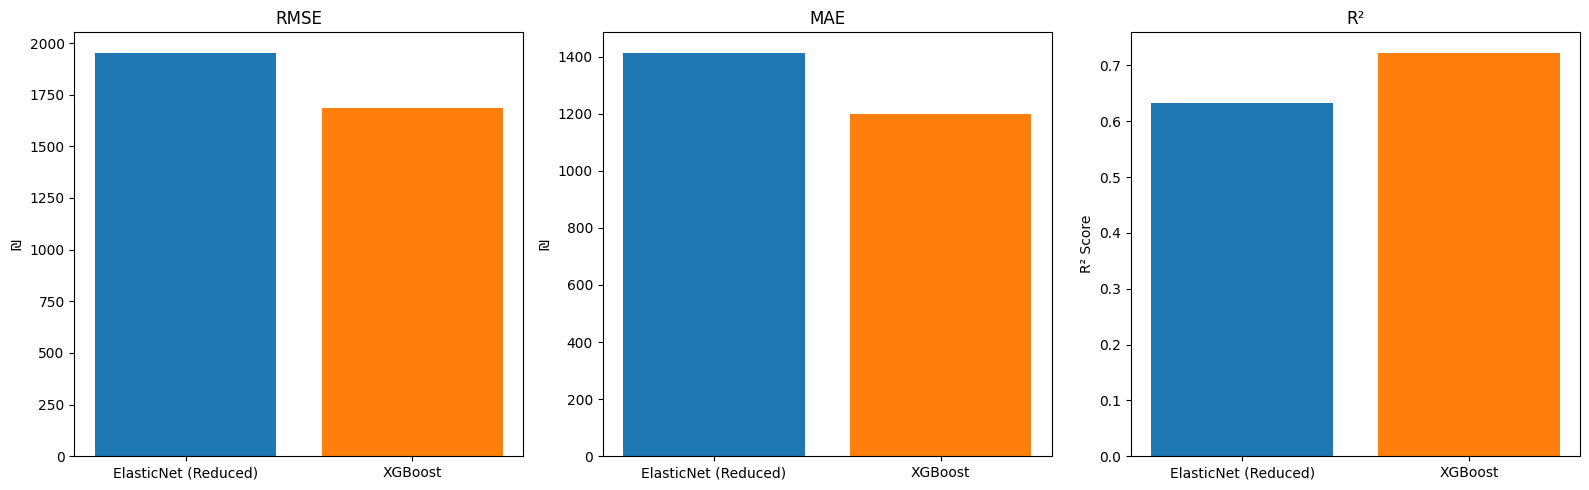

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# טבלת השוואה
results_df = pd.DataFrame({
    "Model": ["ElasticNet (Reduced)", "XGBoost"],
    "RMSE (₪)": [rmse_reduced, rmse_xgb],
    "MAE (₪)":  [mae_reduced, mae_xgb],
    "R²":       [r2_reduced, r2_xgb]
})

# עיגול לתצוגה נוחה
results_df["RMSE (₪)"] = results_df["RMSE (₪)"].round(0).astype(int)
results_df["MAE (₪)"]  = results_df["MAE (₪)"].round(0).astype(int)
results_df["R²"]       = results_df["R²"].round(3)

# צבעים
colors = {"ElasticNet (Reduced)": "#1f77b4", "XGBoost": "#ff7f0e"}
model_colors = results_df["Model"].map(colors)

# הדפסה
print("\nModel Performance Comparison:")
display(results_df.sort_values("RMSE (₪)"))

# גרף
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].bar(results_df["Model"], results_df["RMSE (₪)"], color=model_colors)
axes[0].set_title("RMSE")
axes[0].set_ylabel("₪")

axes[1].bar(results_df["Model"], results_df["MAE (₪)"], color=model_colors)
axes[1].set_title("MAE")
axes[1].set_ylabel("₪")

axes[2].bar(results_df["Model"], results_df["R²"], color=model_colors)
axes[2].set_title("R²")
axes[2].set_ylabel("R² Score")

plt.tight_layout()
plt.show()


#### Based on the results shown in the table and bar plots, the XGBoost model clearly outperforms ElasticNet:

###### - Lower RMSE  means that XGBoost has smaller average errors in predictions.

###### - Lower MAE  confirms it makes fewer large mistakes.

###### - Higher R²  means it explains more of the variance in rental prices.

####  Conclusion: XGBoost delivers more accurate and reliable predictions in this case.

In [11]:
top_features_comparison = pd.DataFrame({
    "ElasticNet (Reduced)": top5_reduced["feature"].values,
    "XGBoost": top5_xgb["feature"].values
})

print("\nComparison of the Top 5 Most Influential Features Between ElasticNet (Reduced) and XGBoost:")
display(top_features_comparison)



Comparison of the Top 5 Most Influential Features Between ElasticNet (Reduced) and XGBoost:


,ElasticNet (Reduced),XGBoost
0,property_type_דופלקס,area
1,area,area_x_elevator
2,property_type_דירה,neighborhood
3,property_type_סטודיו/לופט,has_parking
4,room_num,ac


#### Differences and Similarities Between the Models:
###### - Both models ranked area among their top 2 features, confirming its strong correlation with rental price — as it directly reflects apartment size.

###### - ElasticNet (Reduced) relies on categorical features like property_type_דופלקס, דירה, סטודיו/לופט and numeric room_num, likely because it captures direct additive effects.

###### - XGBoost, being a tree-based model, can detect nonlinear patterns and interactions, which explains the inclusion of engineered or complex features like area_x_elevator, has_parking, and ac.

#### The differences in top features reflect the models’ nature:

###### - ElasticNet captures linear relationships

###### - XGBoost captures nonlinear splits and interactions

###### - Performance-wise, XGBoost still outperformed ElasticNet across all evaluation metrics — likely because of its better ability to adapt to complex patterns in the data.

